## Example 2: Dynamics in Fenna-Mathews-Olsen complex (FMO)

### Introduction

In this example notebook we outline how to employ the HEOM to 
solve the FMO photosynthetic complex dynamics. 


We aim to replicate the results in reference https://www.pnas.org/content/106/41/17255
and compare them to a Bloch-Redfield (perturbative) solution.

This demonstrates how to to employ the solver for multiple baths, as well as showing how a
quantum environment reduces the effect of pure dephasing.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import contextlib
import time

import numpy as np

from qutip import *
from qutip.nonmarkov.heom import HEOMSolver, HSolverDL, BosonicBath, DrudeLorentzBath, DrudeLorentzPadeBath
from qutip.ipynbtools import HTMLProgressBar

In [8]:
def cot(x):
    return 1./np.tan(x)


def J0(energy):
    #underdamped brownian oscillator

    return 2 * lam * gamma * (energy)/( ((energy**2) + (gamma**2)))

def dl_corr_approx(t, nk):
    """ Drude-Lorenz correlation function approximation.
    
        Approximates the correlation function at each time t to nk exponents.
    """
    c = lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t)
    for k in range(1, nk):
        vk = 2 * np.pi * k * T
        c += (4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(-vk * t)
    return c

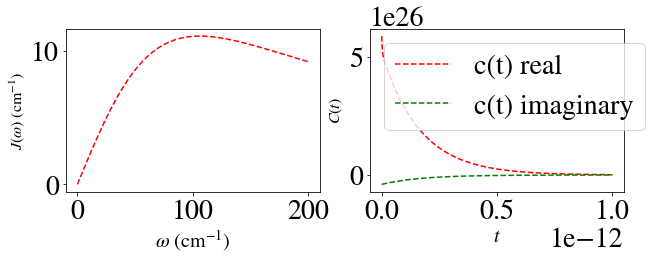

In [27]:
#A quick plot of the spectral density and environment correlation functions


wlist = linspace(0, 200*3e10*2*pi,100)
lam = 35 * 3e10 * 2 * pi
gamma = (1/(166e-15))
T = 300 * 0.6949 * 3e10 * 2 * pi

beta = 1/T


tlist = linspace(0,1.e-12,1000)


J = [J0(w)/(3e10*2*pi) for w in wlist]


fig, axes = plt.subplots(1, 2, sharex=False, figsize=(10,3))

fig.subplots_adjust(hspace=0.1) # reduce space between plots

axes[0].plot(wlist/(3e10*2*pi), J, color='r',ls='--')
axes[0].set_xlabel(r'$\omega$ (cm$^{-1}$)', fontsize=20)
axes[0].set_ylabel(r"$J(\omega)$ (cm$^{-1}$)", fontsize=16);
axes[1].plot(tlist, [np.real(dl_corr_approx(t,10))for t in tlist], color='r',ls='--',label="c(t) real")
axes[1].plot(tlist, [np.imag(dl_corr_approx(t,10)) for t in tlist], color='g',ls='--',label="c(t) imaginary")
axes[1].set_xlabel(r'$t$', fontsize=20)
axes[1].set_ylabel(r"$C(t)$", fontsize=16);

axes[1].legend(loc=0)

#fig.savefig("figures/drude.pdf")

In [14]:
#We use the Hamiltonian employed in  https://www.pnas.org/content/106/41/17255 and operate in units of Hz
Hsys =  3e10 * 2 * pi *Qobj([[200, -87.7, 5.5, -5.9, 6.7, -13.7, -9.9],
                    [-87.7, 320, 30.8, 8.2, 0.7, 11.8, 4.3],
                    [5.5, 30.8, 0, -53.5, -2.2, -9.6, 6.0],
                    [-5.9, 8.2, -53.5, 110, -70.7, -17.0, -63.3],
                    [6.7, 0.7, -2.2, -70.7, 270, 81.1, -1.3],
                    [-13.7,11.8, -9.6, -17.0 ,81.1, 420, 39.7],
                    [-9.9, 4.3, 6.0, -63.3, -1.3, 39.7, 230]])


#start the excitation at site :1:
rho0 = basis(7,0)*basis(7,0).dag() 

optionsODE = Options(nsteps=15000, store_states=True)
#
Nc = 8

Nk = 0

Q_list = []
baths= []
Ltot = liouvillian(Hsys)
for m in range(7):
    Q=basis(7,m)*basis(7,m).dag()
    Q_list.append(Q)
    baths.append(DrudeLorentzBath(
            Q,lam=lam, gamma=gamma, T=T, Nk=Nk,
        tag=str(m)))
    _, terminator = baths[-1].terminator()  #Here we set Nk=0 and
                                            #rely on the terminator 
                                            # to correct detailed balance
    Ltot += terminator

In [15]:
HEOMMats = HEOMSolver(Hsys, baths, Nc, options=optionsODE)
outputFMOHEOM=HEOMMats.run(rho0,tlist)

In [16]:
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['axes.labelsize'] = 30
matplotlib.rcParams['xtick.labelsize'] = 28
matplotlib.rcParams['ytick.labelsize'] = 28
matplotlib.rcParams['legend.fontsize'] = 28
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rcParams['font.family'] = 'STIXgeneral' 
matplotlib.rcParams['mathtext.fontset'] =  'stix'
matplotlib.rcParams["font.serif"] = "STIX"
matplotlib.rcParams['text.usetex'] = False

In [17]:
from cycler import cycler

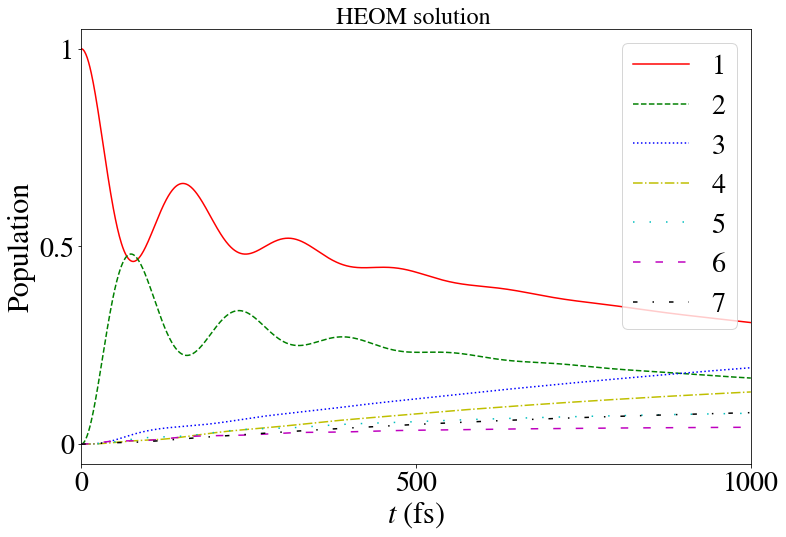

In [22]:
fig, axes = plt.subplots(1,1, figsize=(12,8))

default_cycler = (cycler(color=['r', 'g', 'b', 'y','c','m','k']) +
                  cycler(linestyle=['-', '--', ':', '-.',(0, (1, 10)), (0, (5, 10)),(0, (3, 10, 1, 10))]))
plt.rc('axes',prop_cycle=default_cycler )

for m in range(7):
    Q =  basis(7,m)*basis(7,m).dag()
    axes.plot(array(tlist)*1e15, expect(outputFMOHEOM.states,Q),label=m+1)    
axes.set_xlabel(r'$t$ (fs)', fontsize=30)
axes.set_ylabel(r"Population", fontsize=30);
axes.locator_params(axis='y', nbins=6)
axes.locator_params(axis='x', nbins=6)

axes.set_title('HEOM solution ',fontsize=24)
axes.legend(loc=0)
axes.set_xlim(0,1000)
plt.yticks([0.,0.5,1],[0,0.5,1])
plt.xticks([0.,500,1000],[0,500,1000])
#fig.savefig("figures/fmoheom.pdf")

([<matplotlib.axis.XTick at 0x7ff83a36cfd0>,
 [Text(0.0, 0, '0'), Text(500.0, 0, '500'), Text(1000.0, 0, '1000')])

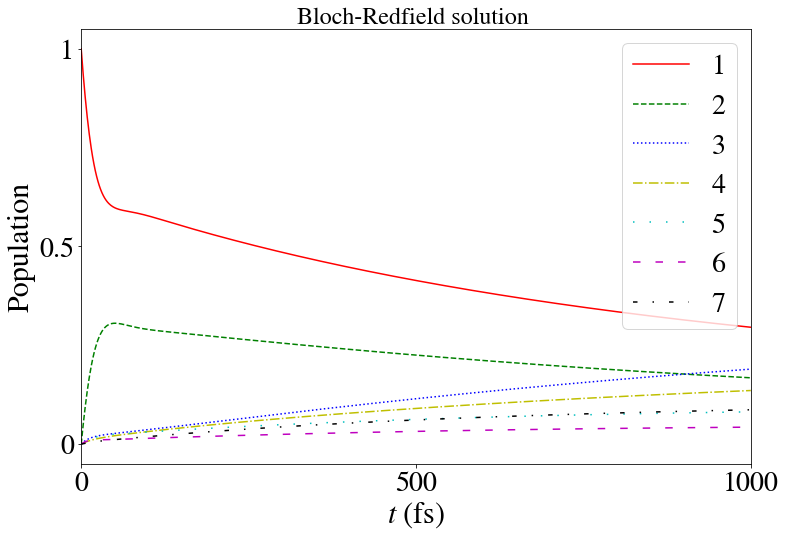

In [23]:
DL = " 2*pi* 2.0 * {lam} / (pi * {gamma} * {beta})  if (w==0) else 2*pi*(2.0*{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) * ((1/(exp((w) * {beta})-1))+1)".format(gamma=gamma, beta = beta, lam = lam)


Nmax = 7
Q_list = [basis(Nmax, n)*basis(Nmax, n).dag() for n in range(Nmax)]

optionsODE = Options(nsteps=15000, store_states=True,rtol=1e-12,atol=1e-12)
outputBR  =  brmesolve(Hsys, rho0, tlist, a_ops=[[Q,DL] for Q in Q_list], options = optionsODE)


fig, axes = plt.subplots(1,1, figsize=(12,8))
for m,Q in enumerate(Q_list):
    axes.plot(array(tlist)*1e15, expect(outputBR.states,Q),label=m+1)

axes.set_xlabel(r'$t$ (fs)', fontsize=30)
axes.set_ylabel(r"Population", fontsize=30);

axes.set_title('Bloch-Redfield solution ',fontsize=24)
axes.legend(loc=0)
axes.set_xlim(0,1000)
plt.yticks([0.,0.5,1],[0,0.5,1])
plt.xticks([0.,500,1000],[0,500,1000])
#fig.savefig("figures/fmoBR.pdf")

 # Role of pure dephasing
 
 It is more useful to explicitly construct the various parts of the Bloch-Redfield master equation explicitly, and show that it is the pure-dephasing which suppresses coherence in these oscillations.

In [39]:
def n_th(energy):
   
    beta=1./Temperature
    
    return 1./(np.exp(energy*beta) - 1.)

def J0(energy):
    #underdamped brownian oscillator
 
    return 2 * lam * gamma * (energy)/( pi * ((energy**2) + (gamma**2)))

def J02(energy):
    #underdamped brownian oscillator

    return 2 * lam * gamma /(np.pi * ((gamma**2)))


def get_collapse(dephasing = 1):
    all_energy, all_state = Hsys.eigenstates()

    Nmax = 7


    Q_list = [basis(Nmax, n)*basis(Nmax, n).dag() for n in range(Nmax)]



    collapse_list = []

    for Q in Q_list:
        for j in range(Nmax):

            for k in range(j+1,Nmax):
                Deltajk = abs(all_energy[k] - all_energy[j])
                if abs(Deltajk) > 0 :
                    rate = np.absolute(Q.matrix_element(all_state[j].dag(),all_state[k]))**2 * 2 * pi * J0(Deltajk) * (n_th(Deltajk)+1)
                    if rate > 0.0:
                        collapse_list.append((np.sqrt(rate)*all_state[j]*all_state[k].dag()))  #emission


                    rate = np.absolute(Q.matrix_element(all_state[k].dag(),all_state[j]))**2 * 2 * pi * J0(Deltajk) * (n_th(Deltajk))
                    if rate > 0.0:
                        collapse_list.append((np.sqrt(rate)*all_state[k]*all_state[j].dag())) #absorption
        
        if dephasing:
            for j in range(Nmax):

                rate = np.absolute(Q.matrix_element(all_state[j].dag(),all_state[j]))**2 *  pi * J02(0.) * Temperature
                if rate > 0.0:
                    collapse_list.append((np.sqrt(rate)*all_state[j]*all_state[j].dag()))  #emission
    return collapse_list

We can switch on/off the pure dephasing terms:

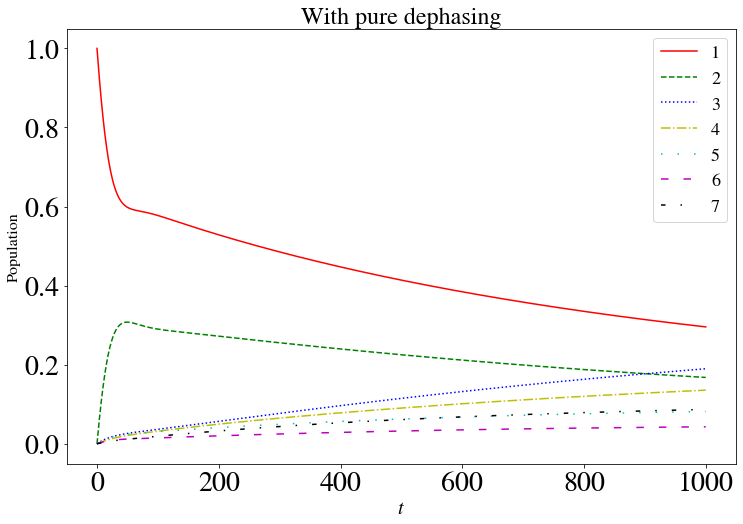

In [42]:
#dephasing terms on, we recover the full BR solution

collapse_list = get_collapse(dephasing=True)
outputFMO = mesolve(Hsys, rho0, tlist, collapse_list)
fig, axes = plt.subplots(1,1, figsize=(12,8))
for m,Q in enumerate(Q_list):
    axes.plot(tlist*1e15, expect(outputFMO.states,Q),label=m+1)
    
axes.set_xlabel(r'$t$', fontsize=20)
axes.set_ylabel(r"Population", fontsize=16);

axes.set_title('With pure dephasing',fontsize=24)
axes.legend(loc=0, fontsize=18)

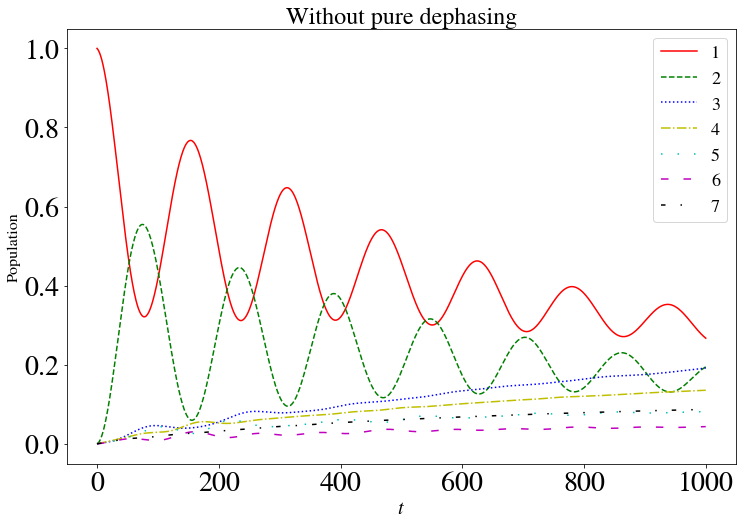

In [43]:
#dephasing terms off

collapse_list = get_collapse(dephasing=False)
outputFMO = mesolve(Hsys, rho0, tlist, collapse_list)
fig, axes = plt.subplots(1,1, figsize=(12,8))
for m,Q in enumerate(Q_list):
    axes.plot(tlist*1e15, expect(outputFMO.states,Q),label=m+1)
    
axes.set_xlabel(r'$t$', fontsize=20)
axes.set_ylabel(r"Population", fontsize=16);

axes.set_title('Without pure dephasing',fontsize=24)
axes.legend(loc=0, fontsize=18)

### Software versions

In [24]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.7.0.dev0+b71625e
Numpy,1.21.2
SciPy,1.7.1
matplotlib,3.5.0
Cython,0.29.25
Number of CPUs,8
BLAS Info,INTEL MKL
IPython,7.29.0
Python,"3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]"
OS,posix [linux]
